<span style="font-width:bold; font-size: 3rem; color:#333;">- Part 02: Daily Feature Pipeline for Air Quality (aqicn.org) and weather (openmeteo)</span>

## 🗒️ This notebook is divided into the following sections:
1. Download and Parse Data
2. Feature Group Insertion


__This notebook should be scheduled to run daily__

In the book, we use a GitHub Action stored here:
[.github/workflows/air-quality-daily.yml](https://github.com/featurestorebook/mlfs-book/blob/main/.github/workflows/air-quality-daily.yml)

However, you are free to use any Python Orchestration tool to schedule this program to run daily.

### <span style='color:#ff5f27'> 📝 Imports

In [1]:
import datetime
import time
import requests
import pandas as pd
import hopsworks
from functions import util
import json
import warnings
warnings.filterwarnings("ignore")

In [2]:
today = datetime.date.today()
yesterday = today - datetime.timedelta(days = 1)

## <span style='color:#ff5f27'> 🌍 STEP 1: Get an AQI API Token and Store it as a Secret in Hopsworks </span>

You have to first get your AQI API key [from here](https://aqicn.org/data-platform/token/):

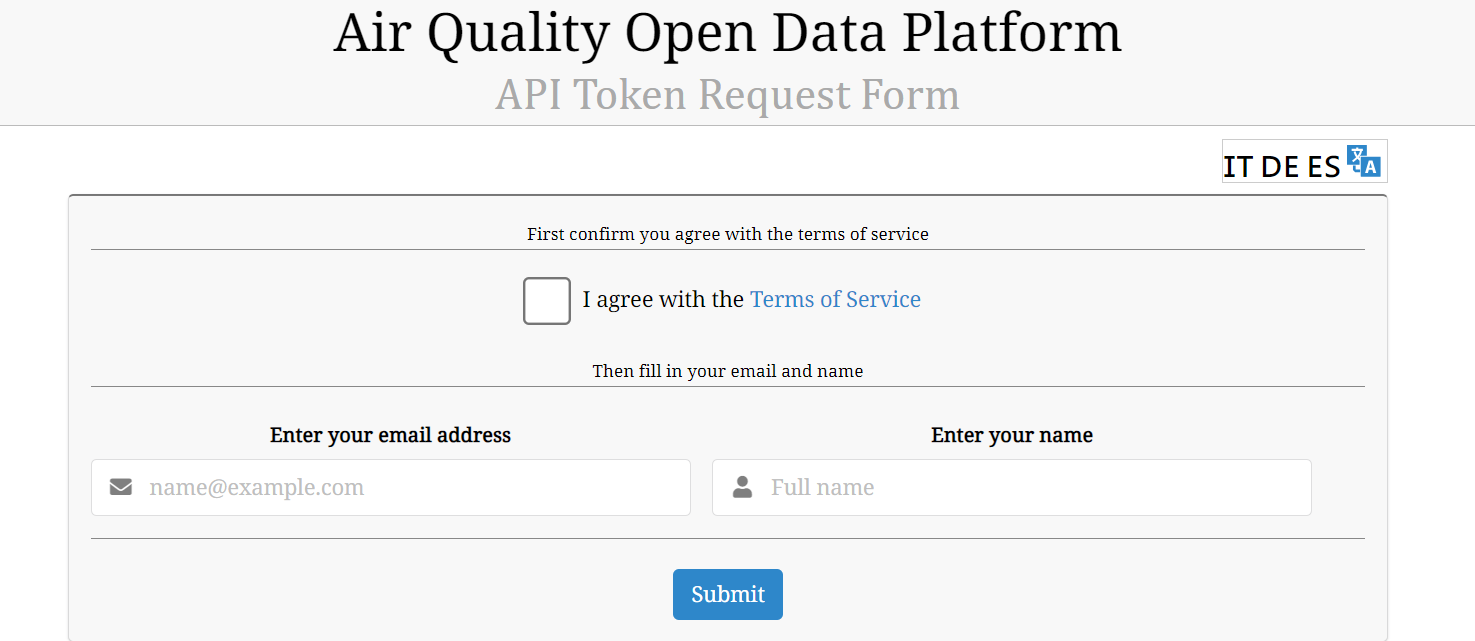


## <span style='color:#ff5f27'> 🌍 STEP 2: Store the AQI API Token as a Secret in Hopsworks </span>

Enter it as a Secret in the Hopsworks UI with the name `AQI_API_KEY` and the value field containing the token string itself

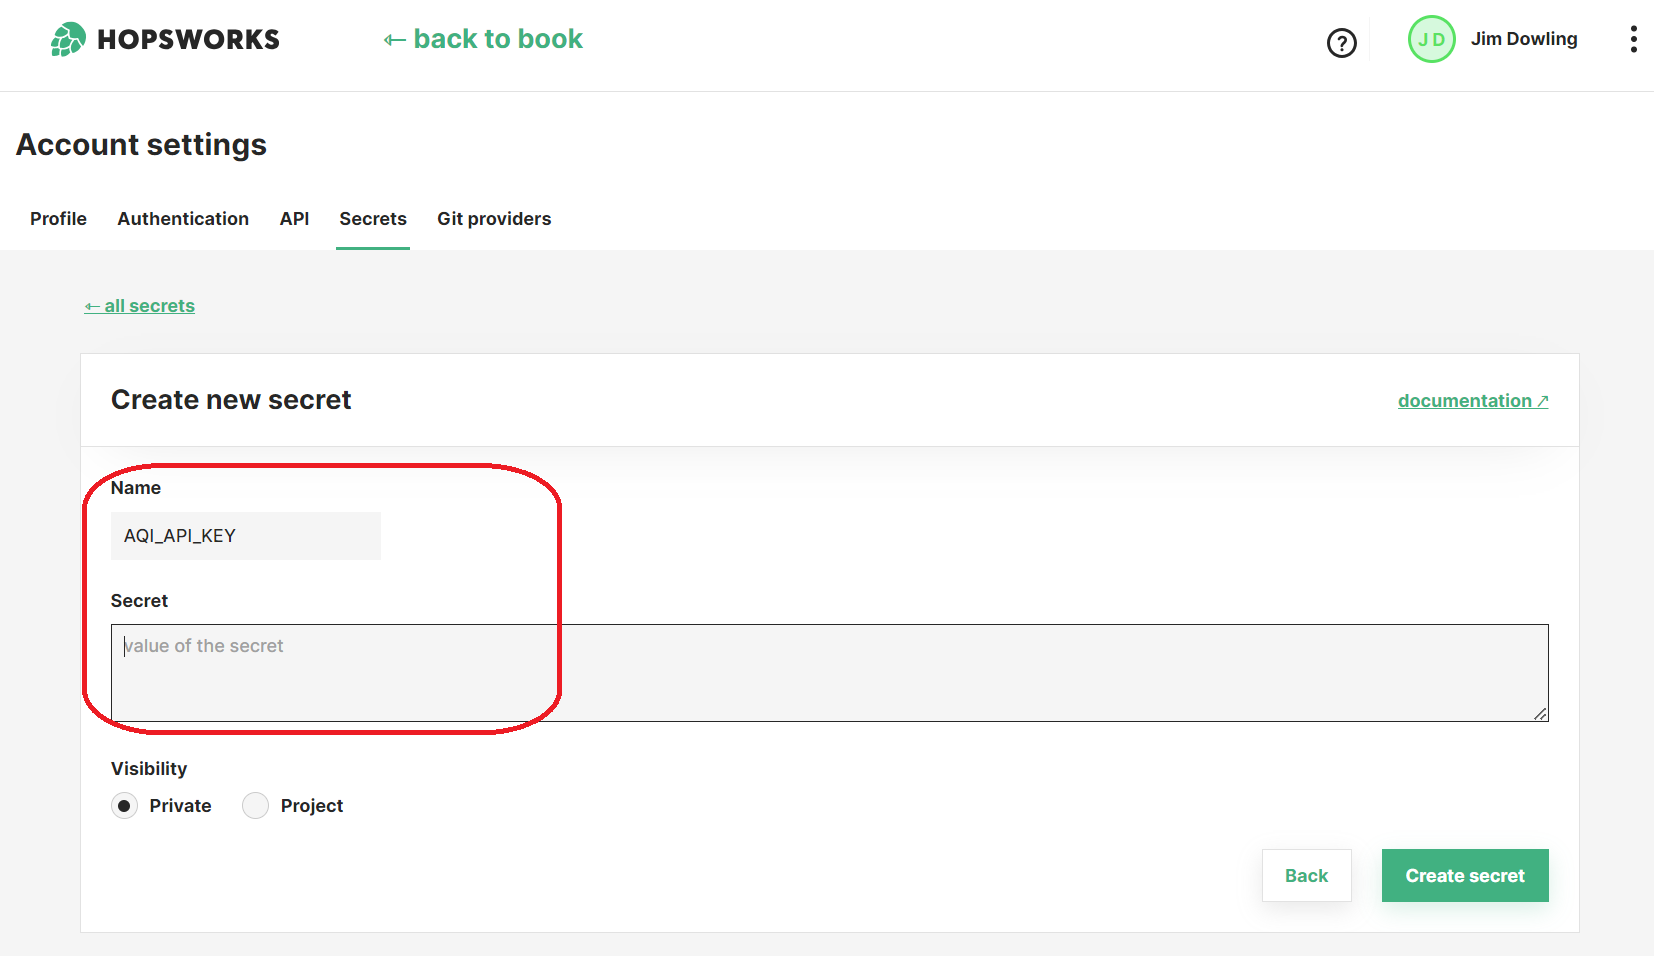

## <span style='color:#ff5f27'> 🌍 STEP 2: Change the Country, City, Street names to match your Sensor </span>

__Update the values in the cell below.__

__These should be the same values as in notebook 1 - the feature backfill notebook__


In [3]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api()

# This line will fail if you have not registered the AQI_API_KEY as a secret in Hopsworks
AQI_API_KEY = secrets.get_secret("AQI_API_KEY").value
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)

country=location['country']
city=location['city']
street=location['street']
aqicn_url=location['aqicn_url']
location_str

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/398
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


'{"country": "usa", "city": "new york", "street": "51st and 8th", "aqicn_url": "https://api.waqi.info/feed/A36655"}'

### <span style="color:#ff5f27;"> 🔮 Get references to the Feature Groups </span>

In [4]:
# Retrieve feature groups
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

---

## <span style='color:#ff5f27'> 🌫 Retrieve Today's Air Quality data (PM2.5) from the AQI API</span>


In [5]:
import requests
import pandas as pd

aq_today_df = util.get_pm25(aqicn_url, country, city, street, today, AQI_API_KEY)
aq_today_df

,pm25,country,city,street,date
0,14.0,usa,new york,51st and 8th,2024-05-04


In [6]:
aq_today_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   pm25     1 non-null      float32       
 1   country  1 non-null      object        
 2   city     1 non-null      object        
 3   street   1 non-null      object        
 4   date     1 non-null      datetime64[ns]
dtypes: datetime64[ns](1), float32(1), object(3)
memory usage: 164.0+ bytes


## <span style='color:#ff5f27'> 🌦 Get Weather Forecast data</span>

In [7]:
hourly_df = util.get_hourly_weather_forecast(city)
hourly_df = hourly_df.set_index('date')

# We will only make 1 daily prediction, so we will replace the hourly forecasts with a single daily forecast
# We only want the daily weather data, so only get weather at 12:00
daily_df = hourly_df.between_time('11:59', '12:01')
daily_df = daily_df.reset_index()
daily_df['date'] = pd.to_datetime(daily_df['date']).dt.date
daily_df['date'] = pd.to_datetime(daily_df['date'])
daily_df['city'] = city
daily_df

Coordinates 40.75°N -74.0°E
Elevation 27.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,url
0,2024-05-04,11.200000,0.0,7.993298,82.234924,new york,https://api.waqi.info/feed/A36655
1,2024-05-05,9.600000,0.1,17.414474,119.744789,new york,https://api.waqi.info/feed/A36655
2,2024-05-06,15.150000,0.0,6.109403,224.999893,new york,https://api.waqi.info/feed/A36655
3,2024-05-07,15.900000,0.0,12.646200,4.899013,new york,https://api.waqi.info/feed/A36655
4,2024-05-08,16.200001,0.0,9.832680,156.250504,new york,https://api.waqi.info/feed/A36655
5,2024-05-09,17.049999,0.0,6.439876,63.435013,new york,https://api.waqi.info/feed/A36655
6,2024-05-10,12.750000,0.0,10.703569,340.346100,new york,https://api.waqi.info/feed/A36655
7,2024-05-11,12.050000,1.0,18.218275,52.224258,new york,https://api.waqi.info/feed/A36655
8,2024-05-12,10.950000,0.1,7.568566,64.653877,new york,https://api.waqi.info/feed/A36655
9,2024-05-13,10.650000,0.0,11.212135,84.472557,new york,https://api.waqi.info/feed/A36655


In [8]:
daily_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         10 non-null     datetime64[ns]
 1   temperature_2m_mean          10 non-null     float32       
 2   precipitation_sum            10 non-null     float32       
 3   wind_speed_10m_max           10 non-null     float32       
 4   wind_direction_10m_dominant  10 non-null     float32       
 5   city                         10 non-null     object        
 6   url                          10 non-null     object        
dtypes: datetime64[ns](1), float32(4), object(2)
memory usage: 528.0+ bytes


## <span style="color:#ff5f27;">⬆️ Uploading new data to the Feature Store</span>

In [9]:
# Insert new data
air_quality_fg.insert(aq_today_df)

FeatureStoreException: Features are not compatible with Feature Group schema: 
 - url (type: 'string') is missing from input dataframe.
Note that feature (or column) names are case insensitive and spaces are automatically replaced with underscores.

In [ ]:
# Insert new data
weather_fg.insert(daily_df)

## <span style="color:#ff5f27;">⏭️ **Next:** Part 03: Training Pipeline
 </span> 

In the following notebook you will read from a feature group and create training dataset within the feature store
